In [1]:
from NMR_predict import GPR_NMR

In [2]:
# Define path to xyz files and path to SOAP files
XYZ_directory = '/home/alex/Pt_NMR/data/structures/'
SOAP_directory = '/home/alex/Pt_NMR/data/representations/SOAP/'

# Define list of SOAP params [r_cut, n_max, l_max]
params = [2.0, 3, 7]

# Create instance of GPR_NMR class
pt_gpr = GPR_NMR(descriptor_path=SOAP_directory, descriptor_type='SOAP',
                 descriptor_params=params, central_atom='Pt', mode ='read', xyz_path=XYZ_directory, xyz_base='st_')


In [4]:
# Define path and column name of the csv where labels (targets) are stored
target_name = 'Experimental'
target_path = '/home/alex/Pt_NMR/data/labels/final_data_corrected'

# Use predict function for GPR and obtaining CV prediction errors
errors_std = pt_gpr.GPR_predict(kernel_degree=2,
                            target_path=target_path, target_name=target_name,
                            normalize=True, noise=1.0, parity_plot=True, noise_estim=True)

print(errors_std)

Descriptor files read: 298 
Average size: 92.938 kB 

Dimensions of design matrix: (298, 11880)


AttributeError: 'GaussianProcessRegressor' object has no attribute 'kernel_'

In [2]:
XYZ_directory = '/home/alex/Pt_NMR/data/structures/'
SOAP_directory = '/home/alex/Pt_NMR/data/representations/APE_RF/'

# Define list of SOAP params [r_cut, n_max, l_max]
params = [3.0, 1000]

# Create instance of GPR_NMR class
pt_gpr = GPR_NMR(descriptor_path=SOAP_directory, descriptor_type='APE_RF',
                 descriptor_params=params, central_atom='Pt', mode ='read', xyz_path=XYZ_directory, xyz_base='st_')

Descriptor files read: 298 
Average size: 7.938 kB 

Dimensions of design matrix: (298, 1000)
Optimized noise level: {'noise_level': 1.0, 'noise_level_bounds': (1e-05, 100000.0)}


/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

RMSE (4-fold CV): 266.3190632429015 [ppm] 7.554692116695008 [ppm] (STDEV)


/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

MAE (4-fold CV): 197.36472077601664 [ppm] 7.847156496950747 [ppm] (STDEV)


/home/alex/anaconda3/envs/Pt_NMR/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


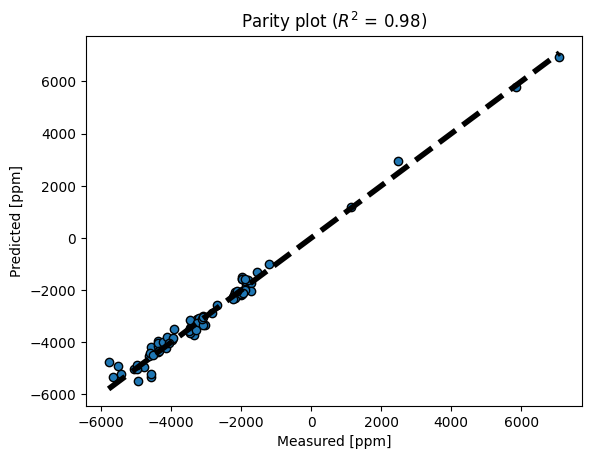

(197.36472077601664, 7.847156496950747, 266.3190632429015, 7.554692116695008)


In [3]:
# Define path and column name of the csv where labels (targets) are stored

target_name = 'Experimental'
target_path = '/home/alex/Pt_NMR/data/labels/final_data_corrected'

# Use predict function for regression and obtaining CV prediction errors

errors_std = pt_gpr.GPR_predict(kernel_degree=2,
                            target_path=target_path, target_name=target_name,
                            normalize=False, noise=1.0, parity_plot=True, noise_estim=True)

print(errors_std)